<a href="https://colab.research.google.com/github/Sowmyasribairisetti/project/blob/master/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory structure created!
Clean files directory: /content/drive/MyDrive/clean_wav
Noise files directory: /content/drive/MyDrive/noise_wav

📁 Checking directories...
Found 20 clean audio files
Sample clean files: ['03-01-02-01-01-01-02.wav', '03-01-01-01-02-01-02.wav', '03-01-01-01-01-01-02.wav']
Found 22 noise audio files
Sample noise files: ['earthquake.wav', 'bubbles.wav', 'sea_wave.wav']

🎚️ Creating SNR mixtures...
Processing 20 clean files and 10 noise files
SNR levels: [-5, 0, 5, 10]
Total mixtures to create: 20 × 10 × 4 = 800


Mixing audio:   0%|          | 0/20 [00:00<?, ?it/s]

Sample mixture: 03-01-01-01-01-01-02_ambience_snr-5dB.wav
  Target SNR: -5 dB, Actual SNR: -5.00 dB
Sample mixture: 03-01-01-01-01-01-02_ambience_snr0dB.wav
  Target SNR: 0 dB, Actual SNR: -0.00 dB
Sample mixture: 03-01-01-01-01-01-02_ambience_snr5dB.wav
  Target SNR: 5 dB, Actual SNR: 5.00 dB


Mixing audio: 100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


✅ Created 800 mixed files in /content/mixed_snr_wav

📊 Preparing STFT dataset...
Processing 800 mixed files for STFT extraction...


Creating STFT: 100%|██████████| 800/800 [00:14<00:00, 54.41it/s]



📦 Creating datasets and dataloaders...
Dataset initialized with 800 files
Dataset sizes — Train: 640, Val: 80, Test: 80

🚀 STARTING RSUNET SPEECH DENOISING TRAINING

🧠 Training RSUNet model...
Model parameters: 2,014,593
🚀 Training on device: cuda


📊 Epoch 5: Train Loss 0.133891, Val Loss 0.227612


📊 Epoch 10: Train Loss 0.094140, Val Loss 0.098620


📊 Epoch 15: Train Loss 0.066196, Val Loss 0.086852


📊 Epoch 20: Train Loss 0.096017, Val Loss 0.097759


⏹️ Early stopping at epoch 24


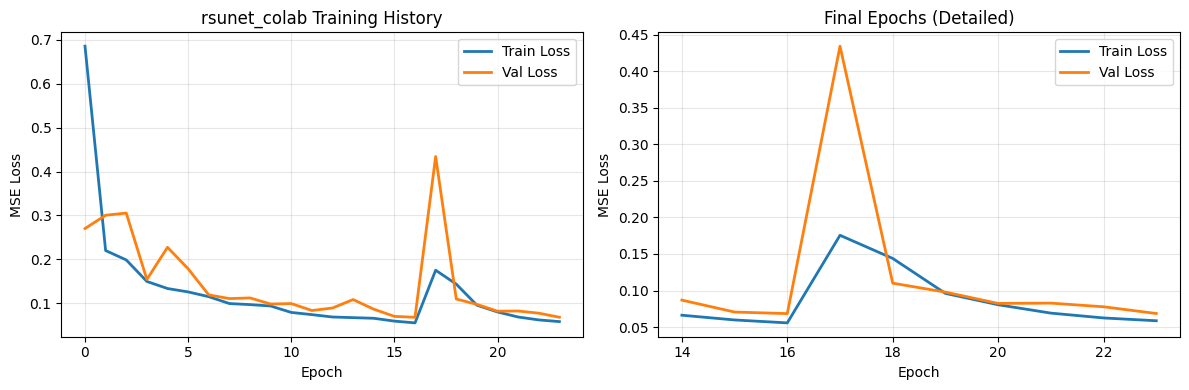


📊 STARTING COMPREHENSIVE EVALUATION

🎵 Evaluating Sample 1/3
💾 Saved enhanced audio: /content/enhanced_audio/03-01-01-01-01-01-02_ambience_snr-5dB_enhanced.wav
📊 Sample: 03-01-01-01-01-01-02_ambience_snr-5dB
   Input SNR: -5.00 dB
   Output SNR: 10.66 dB
   SNR Improvement: 15.66 dB


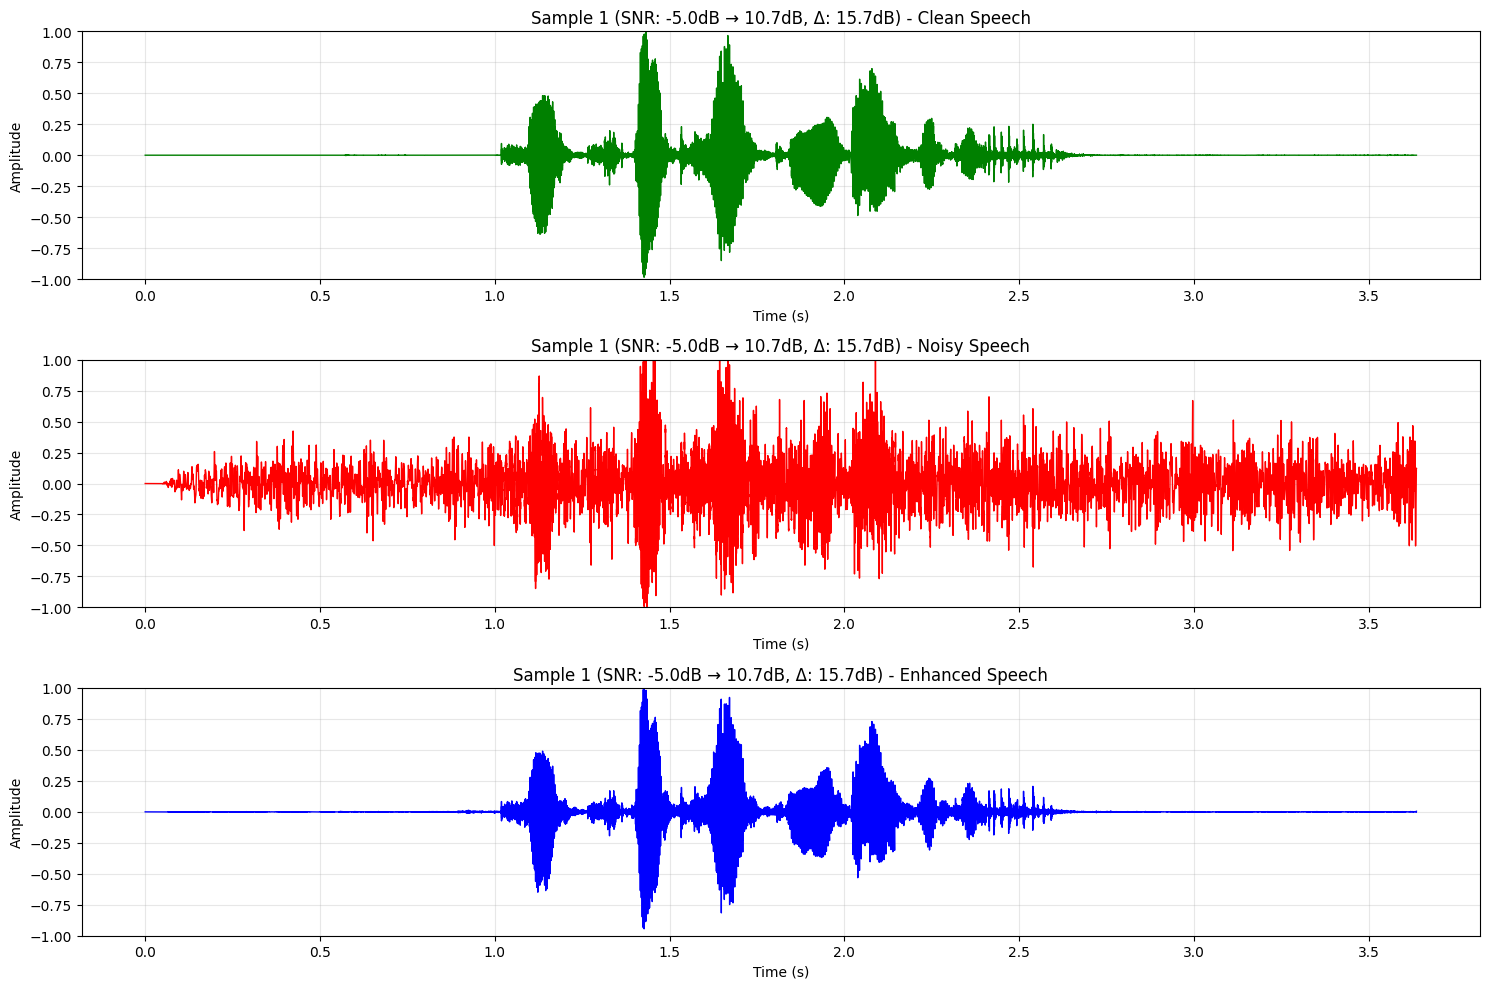

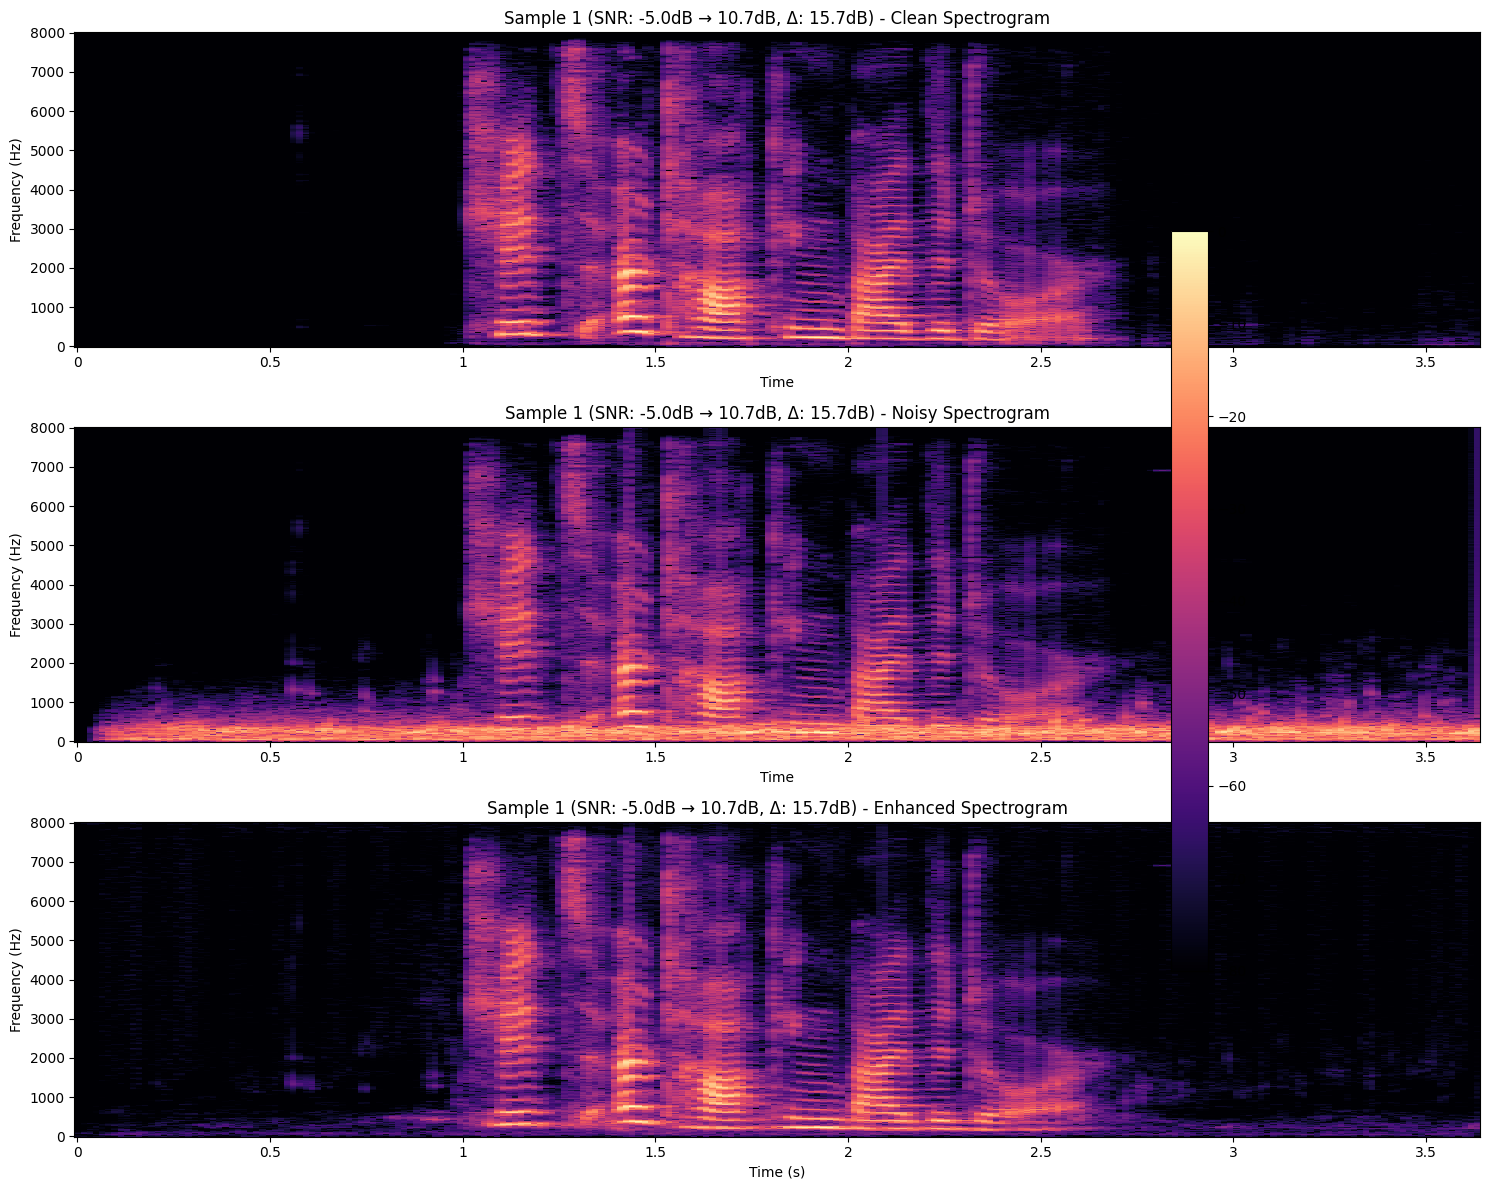

NameError: name 'time_axis' is not defined

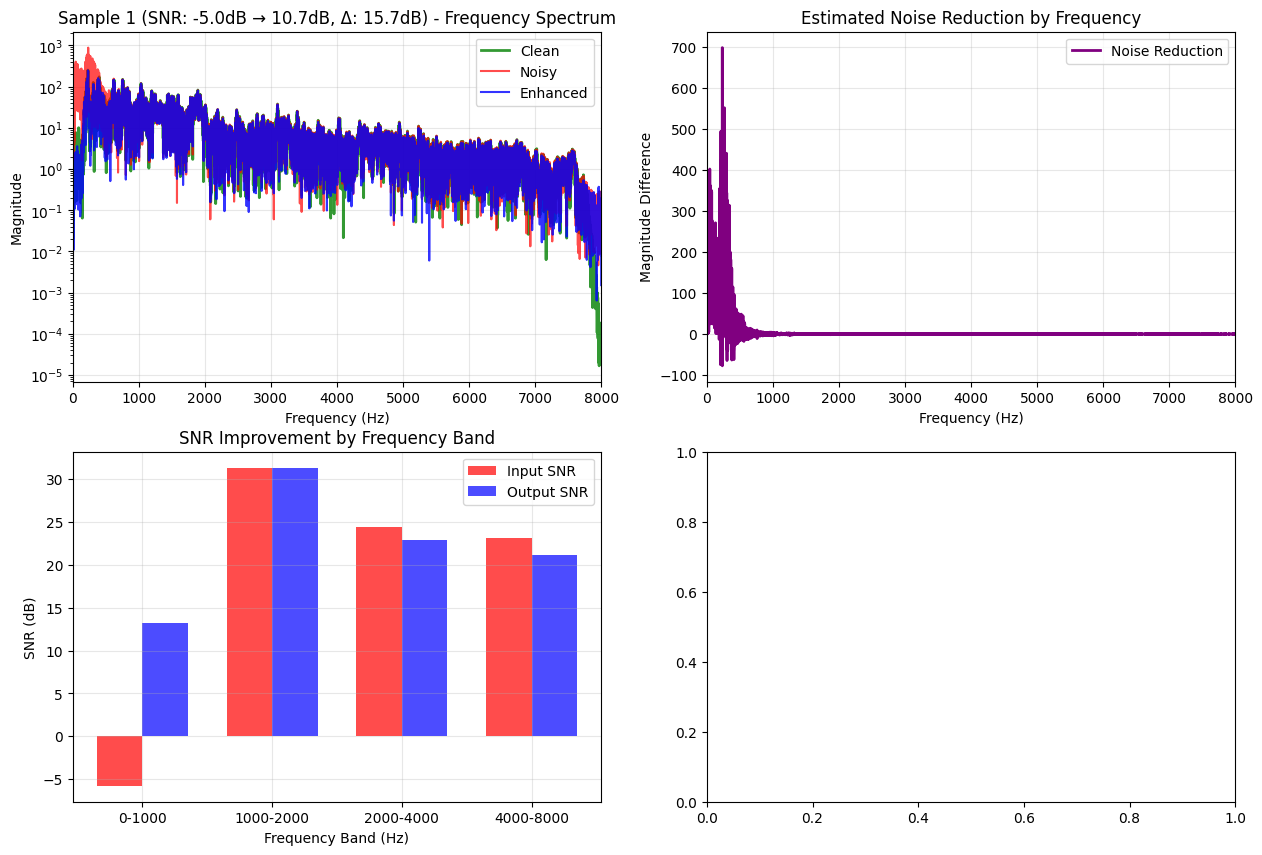

In [1]:
# =============================================
# COMPLETE RSUNet SPEECH DENOISING PIPELINE
# (Modified for Google Colab with Drive Integration)
# =============================================

import os
import re
import numpy as np
import librosa
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import IPython.display as ipd
from google.colab import drive

# -------------------------------
# 1️⃣ MOUNT GOOGLE DRIVE
# -------------------------------
print("Mounting Google Drive...")
drive.mount('/content/drive')

# -------------------------------
# 2️⃣ PATHS (MODIFIED FOR COLAB)
# -------------------------------
# Update these paths to match your Google Drive folder structure
DRIVE_BASE = "/content/drive/MyDrive"

# Adjust these paths to where your clean and noise files are stored in Drive
CLEAN_DIR = os.path.join(DRIVE_BASE, "clean_wav")  # Update if your folder name is different
NOISE_DIR = os.path.join(DRIVE_BASE, "noise_wav")  # Update if your folder name is different

# Create working directories in Colab's temporary storage (faster)
MIX_DIR   = "/content/mixed_snr_wav"
STFT_DIR  = "/content/dataset"
ENHANCED_DIR = "/content/enhanced_audio"

for d in [MIX_DIR, STFT_DIR, ENHANCED_DIR]:
    os.makedirs(d, exist_ok=True)
    os.makedirs(os.path.join(STFT_DIR,"noisy_mag"), exist_ok=True)
    os.makedirs(os.path.join(STFT_DIR,"clean_mag"), exist_ok=True)
    os.makedirs(os.path.join(STFT_DIR,"phase"), exist_ok=True)

print("Directory structure created!")
print(f"Clean files directory: {CLEAN_DIR}")
print(f"Noise files directory: {NOISE_DIR}")

# Check if directories exist and list files
def check_directories():
    print("\n📁 Checking directories...")
    if os.path.exists(CLEAN_DIR):
        clean_files = [f for f in os.listdir(CLEAN_DIR) if f.endswith(".wav")]
        print(f"Found {len(clean_files)} clean audio files")
        if clean_files:
            print(f"Sample clean files: {clean_files[:3]}")
    else:
        print(f"❌ Clean directory not found: {CLEAN_DIR}")
        return False

    if os.path.exists(NOISE_DIR):
        noise_files = [f for f in os.listdir(NOISE_DIR) if f.endswith(".wav")]
        print(f"Found {len(noise_files)} noise audio files")
        if noise_files:
            print(f"Sample noise files: {noise_files[:3]}")
    else:
        print(f"❌ Noise directory not found: {NOISE_DIR}")
        return False

    return True

if not check_directories():
    print("\n⚠️  Please check your Google Drive folder structure!")
    print("Expected structure:")
    print("MyDrive/")
    print("├── clean_wav/")
    print("│   ├── file1.wav")
    print("│   └── file2.wav")
    print("└── noise_wav/")
    print("    ├── noise1.wav")
    print("    └── noise2.wav")

# -------------------------------
# 3️⃣ SNR MIXING FUNCTIONS
# -------------------------------
def calculate_rms(audio):
    return np.sqrt(np.mean(audio**2))

def adjust_noise_to_snr(clean, noise, target_snr_db):
    clean_rms = calculate_rms(clean)
    noise_rms = calculate_rms(noise)
    snr_linear = 10 ** (target_snr_db / 10)
    target_noise_rms = clean_rms / (np.sqrt(snr_linear) + 1e-8)
    scaling_factor = target_noise_rms / (noise_rms + 1e-8)
    return noise * scaling_factor

def mix_at_snr(clean, noise, target_snr_db):
    min_len = min(len(clean), len(noise))
    clean, noise = clean[:min_len], noise[:min_len]

    # Normalize clean audio
    clean = clean / (np.max(np.abs(clean)) + 1e-8)

    # Scale noise to target SNR
    scaled_noise = adjust_noise_to_snr(clean, noise, target_snr_db)

    # Mix
    mixed = clean + scaled_noise

    # Clip to prevent distortion
    mixed = np.clip(mixed, -1.0, 1.0)

    actual_snr = 10*np.log10(np.mean(clean**2)/(np.mean(scaled_noise**2)+1e-8))
    return mixed, scaled_noise, actual_snr

def prepare_snr_mixes(clean_dir, noise_dir, mix_dir, snr_levels=[-5,0,5,10], sr=16000, max_files=50):
    clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith(".wav")])[:max_files]
    noise_files = sorted([f for f in os.listdir(noise_dir) if f.endswith(".wav")])[:10]  # Limit noise files

    print(f"Processing {len(clean_files)} clean files and {len(noise_files)} noise files")
    print(f"SNR levels: {snr_levels}")
    print(f"Total mixtures to create: {len(clean_files)} × {len(noise_files)} × {len(snr_levels)} = {len(clean_files)*len(noise_files)*len(snr_levels)}")

    mixture_count = 0
    for clean_file in tqdm(clean_files, desc="Mixing audio"):
        clean_path = os.path.join(clean_dir, clean_file)
        clean_audio, _ = librosa.load(clean_path, sr=sr)

        for noise_file in noise_files:
            noise_path = os.path.join(noise_dir, noise_file)
            noise_audio, _ = librosa.load(noise_path, sr=sr)

            for snr_db in snr_levels:
                mixed_audio, scaled_noise, actual_snr = mix_at_snr(clean_audio, noise_audio, snr_db)
                mix_name = f"{clean_file[:-4]}_{noise_file[:-4]}_snr{snr_db}dB.wav"
                sf.write(os.path.join(mix_dir, mix_name), mixed_audio, sr)
                mixture_count += 1

                # Print sample verification for first few mixtures
                if mixture_count <= 3:
                    print(f"Sample mixture: {mix_name}")
                    print(f"  Target SNR: {snr_db} dB, Actual SNR: {actual_snr:.2f} dB")

    print(f"✅ Created {mixture_count} mixed files in {mix_dir}")

# Create SNR mixtures
print("\n🎚️ Creating SNR mixtures...")
prepare_snr_mixes(CLEAN_DIR, NOISE_DIR, MIX_DIR)

# -------------------------------
# 4️⃣ STFT DATASET PREPARATION
# -------------------------------
def prepare_stft_dataset(clean_dir, mixed_dir, output_root, sr=16000, n_fft=1024, hop_length=256):
    mixed_files = [f for f in os.listdir(mixed_dir) if f.endswith(".wav")]
    print(f"Processing {len(mixed_files)} mixed files for STFT extraction...")

    for f in tqdm(mixed_files, desc="Creating STFT"):
        clean_id = f.split("_")[0]
        clean_path = os.path.join(clean_dir, clean_id+".wav")
        if not os.path.exists(clean_path):
            continue

        # Load the mixed file
        noisy, _ = librosa.load(os.path.join(mixed_dir,f), sr=sr)

        # Load the original clean file
        clean_orig, _ = librosa.load(clean_path, sr=sr)

        min_len = min(len(noisy), len(clean_orig))
        noisy = noisy[:min_len]
        clean_orig = clean_orig[:min_len]

        # Use normalized clean signal for training target
        clean_normalized = clean_orig / (np.max(np.abs(clean_orig)) + 1e-8)

        noisy_stft = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length)
        clean_stft = librosa.stft(clean_normalized, n_fft=n_fft, hop_length=hop_length)

        noisy_mag, clean_mag, phase = np.abs(noisy_stft), np.abs(clean_stft), np.angle(noisy_stft)
        base_name = f.replace(".wav","")
        np.save(os.path.join(output_root,"noisy_mag",f"{base_name}_noisy_mag.npy"), noisy_mag)
        np.save(os.path.join(output_root,"clean_mag",f"{base_name}_clean_mag.npy"), clean_mag)
        np.save(os.path.join(output_root,"phase",f"{base_name}_phase.npy"), phase)

print("\n📊 Preparing STFT dataset...")
prepare_stft_dataset(CLEAN_DIR, MIX_DIR, STFT_DIR)

# -------------------------------
# 5️⃣ DATASET CLASS
# -------------------------------
class SpeechDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, max_frames=256):
        self.noisy_files = sorted([f for f in os.listdir(noisy_dir) if f.endswith(".npy")])
        self.clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith(".npy")])
        self.noisy_dir, self.clean_dir, self.max_frames = noisy_dir, clean_dir, max_frames
        print(f"Dataset initialized with {len(self.noisy_files)} files")

    def pad_or_crop(self, x):
        freq,time = x.shape
        if time < self.max_frames:
            pad = np.zeros((freq,self.max_frames-time))
            x = np.concatenate([x,pad],axis=1)
        else:
            x = x[:,:self.max_frames]
        return x

    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        noisy = np.load(os.path.join(self.noisy_dir,self.noisy_files[idx]))
        clean = np.load(os.path.join(self.clean_dir,self.clean_files[idx]))
        noisy, clean = self.pad_or_crop(noisy), self.pad_or_crop(clean)
        return torch.tensor(noisy).unsqueeze(0).float(), torch.tensor(clean).unsqueeze(0).float()

# Create datasets
print("\n📦 Creating datasets and dataloaders...")
noisy_dir_stft = os.path.join(STFT_DIR,"noisy_mag")
clean_dir_stft = os.path.join(STFT_DIR,"clean_mag")
dataset = SpeechDataset(noisy_dir_stft, clean_dir_stft, max_frames=256)

train_len = int(0.8*len(dataset))
val_len   = int(0.1*len(dataset))
test_len  = len(dataset)-train_len-val_len
train_ds, val_ds, test_ds = random_split(dataset,[train_len,val_len,test_len])

train_dl = DataLoader(train_ds,batch_size=8,shuffle=True)
val_dl   = DataLoader(val_ds,batch_size=8)
test_dl  = DataLoader(test_ds,batch_size=8)

print(f"Dataset sizes — Train: {train_len}, Val: {val_len}, Test: {test_len}")

# -------------------------------
# 6️⃣ RSUNET MODEL
# -------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.skip = nn.Conv2d(in_c,out_c,1) if in_c!=out_c else nn.Identity()
    def forward(self,x):
        residual = self.skip(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x+residual)

class RSUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ResidualBlock(1,32)
        self.enc2 = ResidualBlock(32,64)
        self.enc3 = ResidualBlock(64,128)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ResidualBlock(128,256)
        self.up3 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.dec3 = ResidualBlock(256,128)
        self.up2 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec2 = ResidualBlock(128,64)
        self.up1 = nn.ConvTranspose2d(64,32,2,stride=2)
        self.dec1 = ResidualBlock(64,32)
        self.out_conv = nn.Conv2d(32,1,1)

    def crop_or_pad(self, src, target):
        diffY = target.size(2)-src.size(2)
        diffX = target.size(3)-src.size(3)
        return F.pad(src, [diffX//2,diffX-diffX//2,diffY//2,diffY-diffY//2])

    def forward(self,x):
        e1=self.enc1(x)
        e2=self.enc2(self.pool(e1))
        e3=self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.up3(b); d3=self.crop_or_pad(d3,e3); d3=torch.cat([d3,e3],1); d3=self.dec3(d3)
        d2 = self.up2(d3); d2=self.crop_or_pad(d2,e2); d2=torch.cat([d2,e2],1); d2=self.dec2(d2)
        d1 = self.up1(d2); d1=self.crop_or_pad(d1,e1); d1=torch.cat([d1,e1],1); d1=self.dec1(d1)
        out = self.out_conv(d1)
        return out

# -------------------------------
# 7️⃣ TRAINING FUNCTION WITH PLOTS
# -------------------------------
def train_model(model, train_dl, val_dl, name, epochs=30, lr=1e-3, patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Training on device: {device}")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss=float('inf'); patience_counter=0
    train_losses,val_losses=[],[]

    for epoch in range(epochs):
        model.train(); train_loss=0
        for x,y in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            x,y=x.to(device),y.to(device)
            optimizer.zero_grad()
            loss=criterion(model(x),y)
            loss.backward(); optimizer.step()
            train_loss+=loss.item()
        train_loss/=len(train_dl)

        model.eval(); val_loss=0
        with torch.no_grad():
            for x,y in val_dl:
                x,y=x.to(device),y.to(device)
                val_loss+=criterion(model(x),y).item()
        val_loss/=len(val_dl)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss<best_val_loss:
            best_val_loss=val_loss
            patience_counter=0
            torch.save({'model_state_dict':model.state_dict()}, f"/content/best_{name}.pth")
        else:
            patience_counter+=1

        if patience_counter>=patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

        if (epoch+1)%5==0:
            print(f"📊 Epoch {epoch+1}: Train Loss {train_loss:.6f}, Val Loss {val_loss:.6f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses,label='Train Loss', linewidth=2)
    plt.plot(val_losses,label='Val Loss', linewidth=2)
    plt.title(f'{name} Training History')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    # Last 10 epochs for detail
    if len(train_losses) > 10:
        plt.plot(range(len(train_losses)-10, len(train_losses)), train_losses[-10:], label='Train Loss', linewidth=2)
        plt.plot(range(len(train_losses)-10, len(train_losses)), val_losses[-10:], label='Val Loss', linewidth=2)
    else:
        plt.plot(train_losses, label='Train Loss', linewidth=2)
        plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.title('Final Epochs (Detailed)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses

# -------------------------------
# 8️⃣ SNR CALCULATION
# -------------------------------
def calculate_snr_proper(clean,noisy):
    min_len=min(len(clean),len(noisy))
    clean,noisy=clean[:min_len],noisy[:min_len]
    noise=noisy-clean
    return 10*np.log10(np.mean(clean**2)/(np.mean(noise**2)+1e-8))

# -------------------------------
# 9️⃣ AUDIO RECONSTRUCTION
# -------------------------------
def reconstruct_audio(model,noisy_mag_path,phase_path,output_dir,sr=16000,max_frames=256):
    os.makedirs(output_dir,exist_ok=True)
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model=model.to(device); model.eval()

    noisy_mag = np.load(noisy_mag_path)
    phase = np.load(phase_path)
    freq,time=noisy_mag.shape
    if time<max_frames:
        noisy_mag_input=np.concatenate([noisy_mag,np.zeros((freq,max_frames-time))],axis=1)
    else:
        noisy_mag_input=noisy_mag[:,:max_frames]

    noisy_tensor=torch.tensor(noisy_mag_input).unsqueeze(0).unsqueeze(0).float().to(device)
    with torch.no_grad():
        enhanced_mag=model(noisy_tensor).cpu().squeeze().numpy()

    freq_mag,time_mag = enhanced_mag.shape
    freq_phase,time_phase=phase.shape
    if time_phase<time_mag:
        phase_aligned=np.concatenate([phase,np.zeros((freq_phase,time_mag-time_phase))],axis=1)
    else:
        phase_aligned=phase[:,:time_mag]

    enhanced_stft=enhanced_mag*np.exp(1j*phase_aligned)
    enhanced_audio=librosa.istft(enhanced_stft)

    output_path=os.path.join(output_dir, os.path.basename(noisy_mag_path).replace("_noisy_mag.npy","_enhanced.wav"))
    sf.write(output_path, enhanced_audio, sr)
    print(f"💾 Saved enhanced audio: {output_path}")
    return output_path

# -------------------------------
# 🔟 ENHANCED VISUALIZATION FUNCTIONS
# -------------------------------
def plot_individual_signals(clean, noisy, enhanced, sr=16000, title_prefix=""):
    time_axis = np.arange(len(clean)) / sr

    plt.figure(figsize=(15, 10))

    # Clean audio plot
    plt.subplot(3, 1, 1)
    plt.plot(time_axis, clean, color='green', linewidth=1)
    plt.title(f"{title_prefix} - Clean Speech")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)

    # Noisy audio plot
    plt.subplot(3, 1, 2)
    plt.plot(time_axis, noisy, color='red', linewidth=1)
    plt.title(f"{title_prefix} - Noisy Speech")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)

    # Enhanced audio plot
    plt.subplot(3, 1, 3)
    plt.plot(time_axis, enhanced, color='blue', linewidth=1)
    plt.title(f"{title_prefix} - Enhanced Speech")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)

    plt.tight_layout()
    plt.show()

def plot_spectrograms(clean, noisy, enhanced, sr=16000, title_prefix=""):
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    # Clean spectrogram
    S_clean = librosa.stft(clean, n_fft=1024, hop_length=256)
    S_db_clean = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
    librosa.display.specshow(S_db_clean, sr=sr, hop_length=256, x_axis='time', y_axis='hz', ax=axes[0])
    axes[0].set_title(f"{title_prefix} - Clean Spectrogram")
    axes[0].set_ylabel("Frequency (Hz)")

    # Noisy spectrogram
    S_noisy = librosa.stft(noisy, n_fft=1024, hop_length=256)
    S_db_noisy = librosa.amplitude_to_db(np.abs(S_noisy), ref=np.max)
    librosa.display.specshow(S_db_noisy, sr=sr, hop_length=256, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title(f"{title_prefix} - Noisy Spectrogram")
    axes[1].set_ylabel("Frequency (Hz)")

    # Enhanced spectrogram
    S_enhanced = librosa.stft(enhanced, n_fft=1024, hop_length=256)
    S_db_enhanced = librosa.amplitude_to_db(np.abs(S_enhanced), ref=np.max)
    im = librosa.display.specshow(S_db_enhanced, sr=sr, hop_length=256, x_axis='time', y_axis='hz', ax=axes[2])
    axes[2].set_title(f"{title_prefix} - Enhanced Spectrogram")
    axes[2].set_ylabel("Frequency (Hz)")
    axes[2].set_xlabel("Time (s)")

    plt.colorbar(im, ax=axes, location='right', shrink=0.8)
    plt.tight_layout()
    plt.show()

def plot_frequency_analysis(clean, noisy, enhanced, sr=16000, title_prefix=""):
    # Compute frequency spectra
    freqs = np.fft.rfftfreq(len(clean), 1/sr)
    clean_fft = np.abs(np.fft.rfft(clean))
    noisy_fft = np.abs(np.fft.rfft(noisy))
    enhanced_fft = np.abs(np.fft.rfft(enhanced))

    plt.figure(figsize=(15, 10))

    # Plot magnitude spectrum
    plt.subplot(2, 2, 1)
    plt.semilogy(freqs, clean_fft, 'g-', label='Clean', alpha=0.8, linewidth=2)
    plt.semilogy(freqs, noisy_fft, 'r-', label='Noisy', alpha=0.7, linewidth=1.5)
    plt.semilogy(freqs, enhanced_fft, 'b-', label='Enhanced', alpha=0.8, linewidth=1.5)
    plt.xlim(0, 8000)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'{title_prefix} - Frequency Spectrum')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot spectral difference (noise reduction)
    plt.subplot(2, 2, 2)
    noise_reduction = noisy_fft - enhanced_fft
    plt.plot(freqs, noise_reduction, 'purple', label='Noise Reduction', linewidth=2)
    plt.xlim(0, 8000)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude Difference')
    plt.title('Estimated Noise Reduction by Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot SNR improvement across frequency bands
    plt.subplot(2, 2, 3)
    freq_bands = [(0, 1000), (1000, 2000), (2000, 4000), (4000, 8000)]
    band_snrs_clean = []
    band_snrs_enhanced = []

    for low, high in freq_bands:
        mask = (freqs >= low) & (freqs < high)
        if np.any(mask):
            clean_power = np.mean(clean_fft[mask]**2)
            noise_power_orig = np.mean((noisy_fft[mask] - clean_fft[mask])**2)
            noise_power_enh = np.mean((enhanced_fft[mask] - clean_fft[mask])**2)

            snr_orig = 10 * np.log10(clean_power / (noise_power_orig + 1e-8))
            snr_enh = 10 * np.log10(clean_power / (noise_power_enh + 1e-8))

            band_snrs_clean.append(snr_orig)
            band_snrs_enhanced.append(snr_enh)

    x_pos = np.arange(len(freq_bands))
    width = 0.35

    plt.bar(x_pos - width/2, band_snrs_clean, width, label='Input SNR', alpha=0.7, color='red')
    plt.bar(x_pos + width/2, band_snrs_enhanced, width, label='Output SNR', alpha=0.7, color='blue')
    plt.xlabel('Frequency Band (Hz)')
    plt.ylabel('SNR (dB)')
    plt.title('SNR Improvement by Frequency Band')
    plt.xticks(x_pos, [f'{low}-{high}' for low, high in freq_bands])
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Combined view
    plt.subplot(2, 2, 4)
    plt.plot(time_axis, clean, 'g-', label='Clean', alpha=0.7)
    plt.plot(time_axis, noisy, 'r-', label='Noisy', alpha=0.4)
    plt.plot(time_axis, enhanced, 'b-', label='Enhanced', alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('All Signals Overlay')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# -------------------------------
# 1️⃣1️⃣ COMPREHENSIVE EVALUATION
# -------------------------------
def comprehensive_evaluation(model, test_files, noisy_dir_stft, STFT_DIR, MIX_DIR, CLEAN_DIR, ENHANCED_DIR, num_samples=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    results = []

    for idx, f in enumerate(test_files[:num_samples]):
        print(f"\n{'='*60}")
        print(f"🎵 Evaluating Sample {idx+1}/{num_samples}")
        print(f"{'='*60}")

        clean_id = f.split("_")[0]
        noisy_path = os.path.join(noisy_dir_stft, f)
        phase_path = os.path.join(STFT_DIR, "phase", f.replace("_noisy_mag.npy", "_phase.npy"))
        clean_wav_path = os.path.join(CLEAN_DIR, clean_id + ".wav")

        base_name = f.replace("_noisy_mag.npy", "")
        noisy_wav_path = os.path.join(MIX_DIR, base_name + ".wav")

        # Reconstruct enhanced audio
        enhanced_wav_path = reconstruct_audio(model, noisy_path, phase_path, ENHANCED_DIR)

        # Load all audio files
        clean_orig, _ = librosa.load(clean_wav_path, sr=16000)
        noisy, _ = librosa.load(noisy_wav_path, sr=16000)
        enhanced, _ = librosa.load(enhanced_wav_path, sr=16000)

        # Align and normalize
        min_len = min(len(clean_orig), len(noisy), len(enhanced))
        clean_orig = clean_orig[:min_len]
        noisy = noisy[:min_len]
        enhanced = enhanced[:min_len]

        clean_normalized = clean_orig / (np.max(np.abs(clean_orig)) + 1e-8)

        # Calculate metrics
        in_snr = calculate_snr_proper(clean_normalized, noisy)
        out_snr = calculate_snr_proper(clean_normalized, enhanced)
        snr_improvement = out_snr - in_snr

        print(f"📊 Sample: {base_name}")
        print(f"   Input SNR: {in_snr:.2f} dB")
        print(f"   Output SNR: {out_snr:.2f} dB")
        print(f"   SNR Improvement: {snr_improvement:.2f} dB")

        # Store results
        results.append({
            'file': base_name,
            'input_snr': in_snr,
            'output_snr': out_snr,
            'snr_improvement': snr_improvement,
            'clean': clean_normalized,
            'noisy': noisy,
            'enhanced': enhanced
        })

        # Generate all plots
        title_suffix = f" (SNR: {in_snr:.1f}dB → {out_snr:.1f}dB, Δ: {snr_improvement:.1f}dB)"

        # 1. Individual signal plots
        plot_individual_signals(clean_normalized, noisy, enhanced,
                               title_prefix=f"Sample {idx+1}{title_suffix}")

        # 2. Spectrogram comparison
        plot_spectrograms(clean_normalized, noisy, enhanced,
                         title_prefix=f"Sample {idx+1}{title_suffix}")

        # 3. Frequency analysis
        plot_frequency_analysis(clean_normalized, noisy, enhanced,
                              title_prefix=f"Sample {idx+1}{title_suffix}")

        # Display audio players
        print("🎧 Audio Playback:")
        display(ipd.Audio(clean_normalized, rate=16000))
        display(ipd.Audio(noisy, rate=16000))
        display(ipd.Audio(enhanced, rate=16000))

    return results

# -------------------------------
# 1️⃣2️⃣ MAIN EXECUTION
# -------------------------------
print("\n" + "="*70)
print("🚀 STARTING RSUNET SPEECH DENOISING TRAINING")
print("="*70)

# Train the model
print("\n🧠 Training RSUNet model...")
rsunet = RSUNet()
print(f"Model parameters: {sum(p.numel() for p in rsunet.parameters()):,}")

trained_model, train_losses, val_losses = train_model(rsunet, train_dl, val_dl, "rsunet_colab", epochs=30)

# Comprehensive evaluation
print("\n" + "="*70)
print("📊 STARTING COMPREHENSIVE EVALUATION")
print("="*70)

test_files = sorted(os.listdir(noisy_dir_stft))
results = comprehensive_evaluation(trained_model, test_files, noisy_dir_stft, STFT_DIR, MIX_DIR, CLEAN_DIR, ENHANCED_DIR, num_samples=3)

# Print summary
print("\n" + "="*70)
print("📈 EVALUATION SUMMARY")
print("="*70)
for i, result in enumerate(results):
    print(f"Sample {i+1}: {result['file']}")
    print(f"  Input SNR: {result['input_snr']:.2f} dB")
    print(f"  Output SNR: {result['output_snr']:.2f} dB")
    print(f"  Improvement: {result['snr_improvement']:.2f} dB")
    print()

avg_improvement = np.mean([r['snr_improvement'] for r in results])
print(f"🎯 Average SNR Improvement: {avg_improvement:.2f} dB")

print("\n✅ Pipeline completed successfully!")
print(f"📁 Enhanced audio saved in: {ENHANCED_DIR}")
print(f"💾 Model saved as: /content/best_rsunet_colab.pth")

In [2]:
def plot_frequency_analysis(clean, noisy, enhanced, sr=16000, title_prefix=""):
    # FIX: Define time_axis
    time_axis = np.arange(len(clean)) / sr

    # Compute frequency spectra
    freqs = np.fft.rfftfreq(len(clean), 1/sr)
    clean_fft = np.abs(np.fft.rfft(clean))
    noisy_fft = np.abs(np.fft.rfft(noisy))
    enhanced_fft = np.abs(np.fft.rfft(enhanced))

    plt.figure(figsize=(15, 10))

    # Plot magnitude spectrum
    plt.subplot(2, 2, 1)
    plt.semilogy(freqs, clean_fft, 'g-', label='Clean', alpha=0.8, linewidth=2)
    plt.semilogy(freqs, noisy_fft, 'r-', label='Noisy', alpha=0.7, linewidth=1.5)
    plt.semilogy(freqs, enhanced_fft, 'b-', label='Enhanced', alpha=0.8, linewidth=1.5)
    plt.xlim(0, 8000)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'{title_prefix} - Frequency Spectrum')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot spectral difference (noise reduction)
    plt.subplot(2, 2, 2)
    noise_reduction = noisy_fft - enhanced_fft
    plt.plot(freqs, noise_reduction, 'purple', label='Noise Reduction', linewidth=2)
    plt.xlim(0, 8000)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude Difference')
    plt.title('Estimated Noise Reduction by Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot SNR improvement across frequency bands
    plt.subplot(2, 2, 3)
    freq_bands = [(0, 1000), (1000, 2000), (2000, 4000), (4000, 8000)]
    band_snrs_clean = []
    band_snrs_enhanced = []

    for low, high in freq_bands:
        mask = (freqs >= low) & (freqs < high)
        if np.any(mask):
            clean_power = np.mean(clean_fft[mask]**2)
            noise_power_orig = np.mean((noisy_fft[mask] - clean_fft[mask])**2)
            noise_power_enh = np.mean((enhanced_fft[mask] - clean_fft[mask])**2)

            snr_orig = 10 * np.log10(clean_power / (noise_power_orig + 1e-8))
            snr_enh = 10 * np.log10(clean_power / (noise_power_enh + 1e-8))

            band_snrs_clean.append(snr_orig)
            band_snrs_enhanced.append(snr_enh)

    x_pos = np.arange(len(freq_bands))
    width = 0.35

    plt.bar(x_pos - width/2, band_snrs_clean, width, label='Input SNR', alpha=0.7, color='red')
    plt.bar(x_pos + width/2, band_snrs_enhanced, width, label='Output SNR', alpha=0.7, color='blue')
    plt.xlabel('Frequency Band (Hz)')
    plt.ylabel('SNR (dB)')
    plt.title('SNR Improvement by Frequency Band')
    plt.xticks(x_pos, [f'{low}-{high}' for low, high in freq_bands])
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Combined view
    plt.subplot(2, 2, 4)
    plt.plot(time_axis, clean, 'g-', label='Clean', alpha=0.7)
    plt.plot(time_axis, noisy, 'r-', label='Noisy', alpha=0.4)
    plt.plot(time_axis, enhanced, 'b-', label='Enhanced', alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('All Signals Overlay')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


📊 STARTING COMPREHENSIVE EVALUATION

🎵 Evaluating Sample 1/3
💾 Saved enhanced audio: /content/enhanced_audio/03-01-01-01-01-01-02_ambience_snr-5dB_enhanced.wav
📊 Sample: 03-01-01-01-01-01-02_ambience_snr-5dB
   Input SNR: -5.00 dB
   Output SNR: 10.66 dB
   SNR Improvement: 15.66 dB


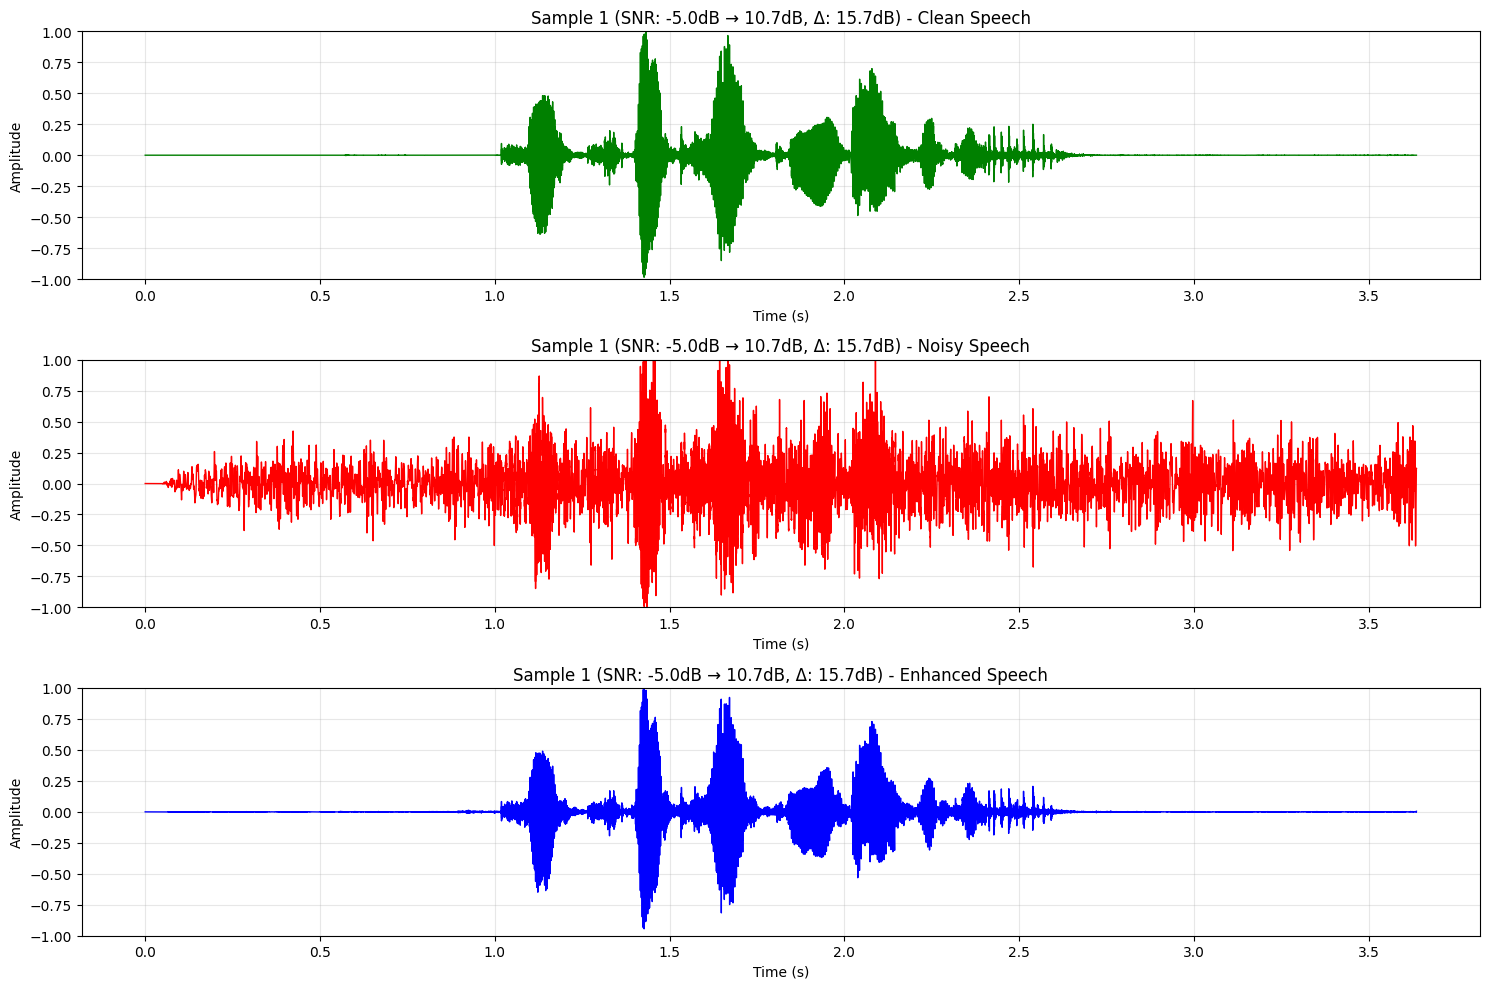

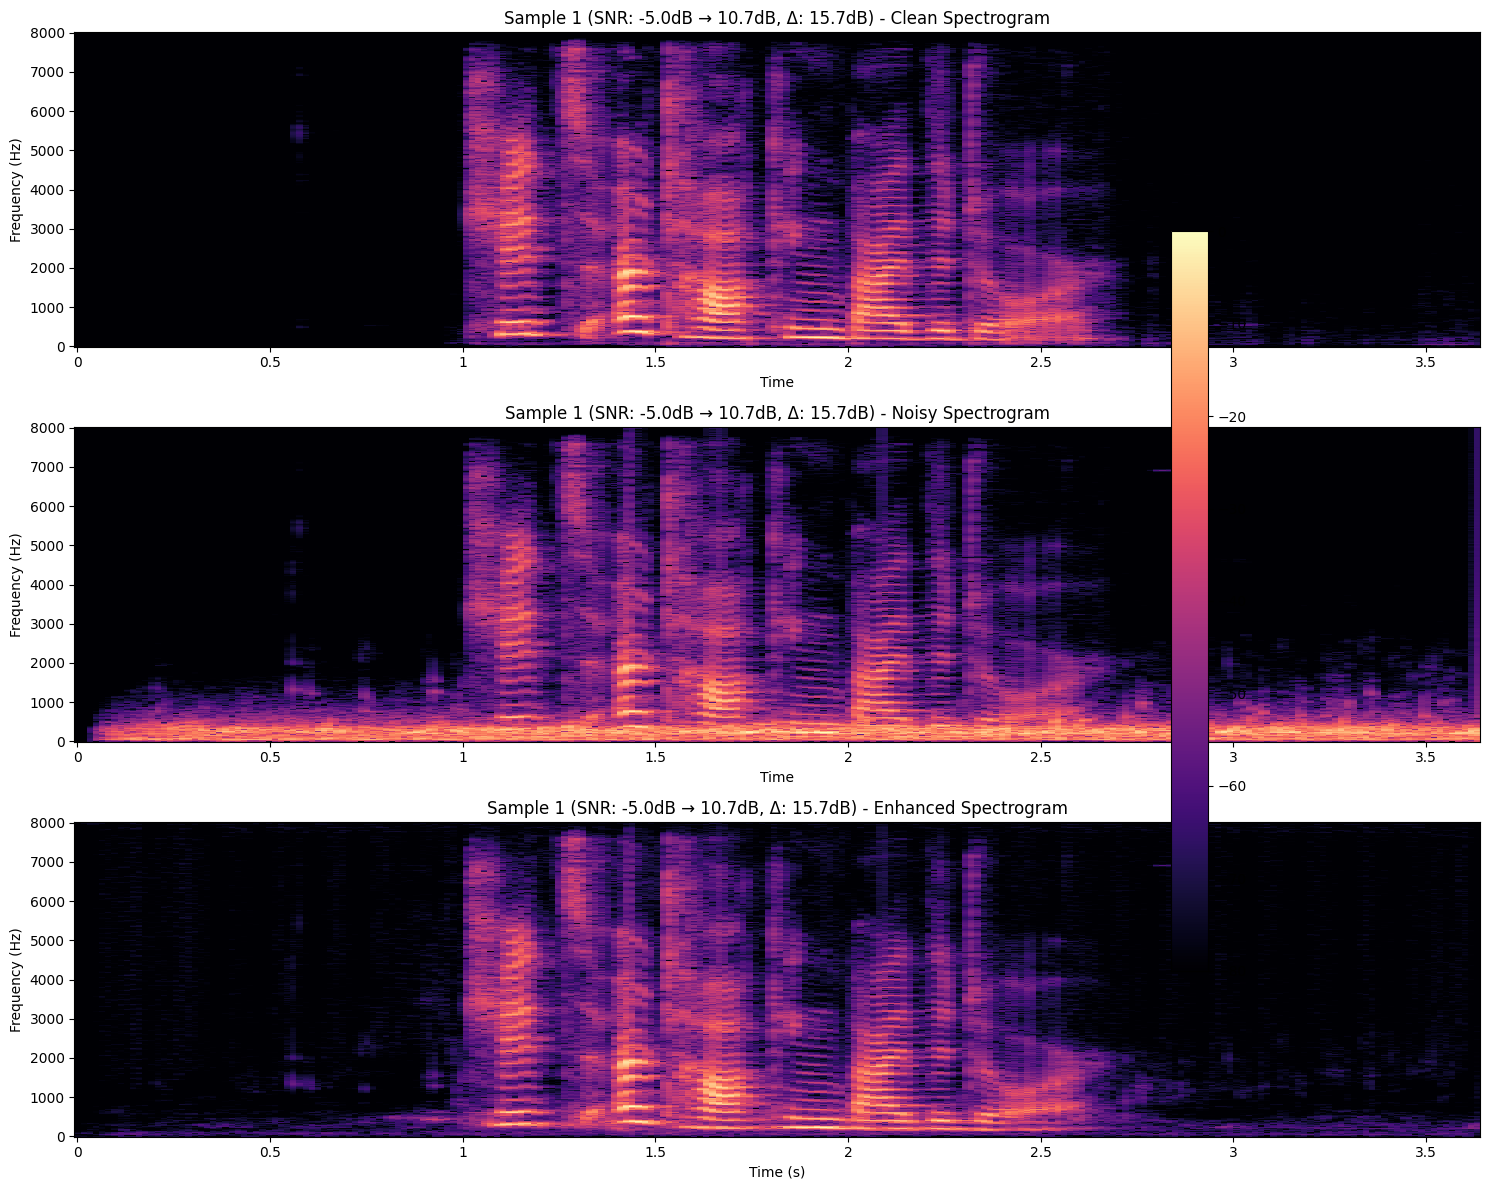

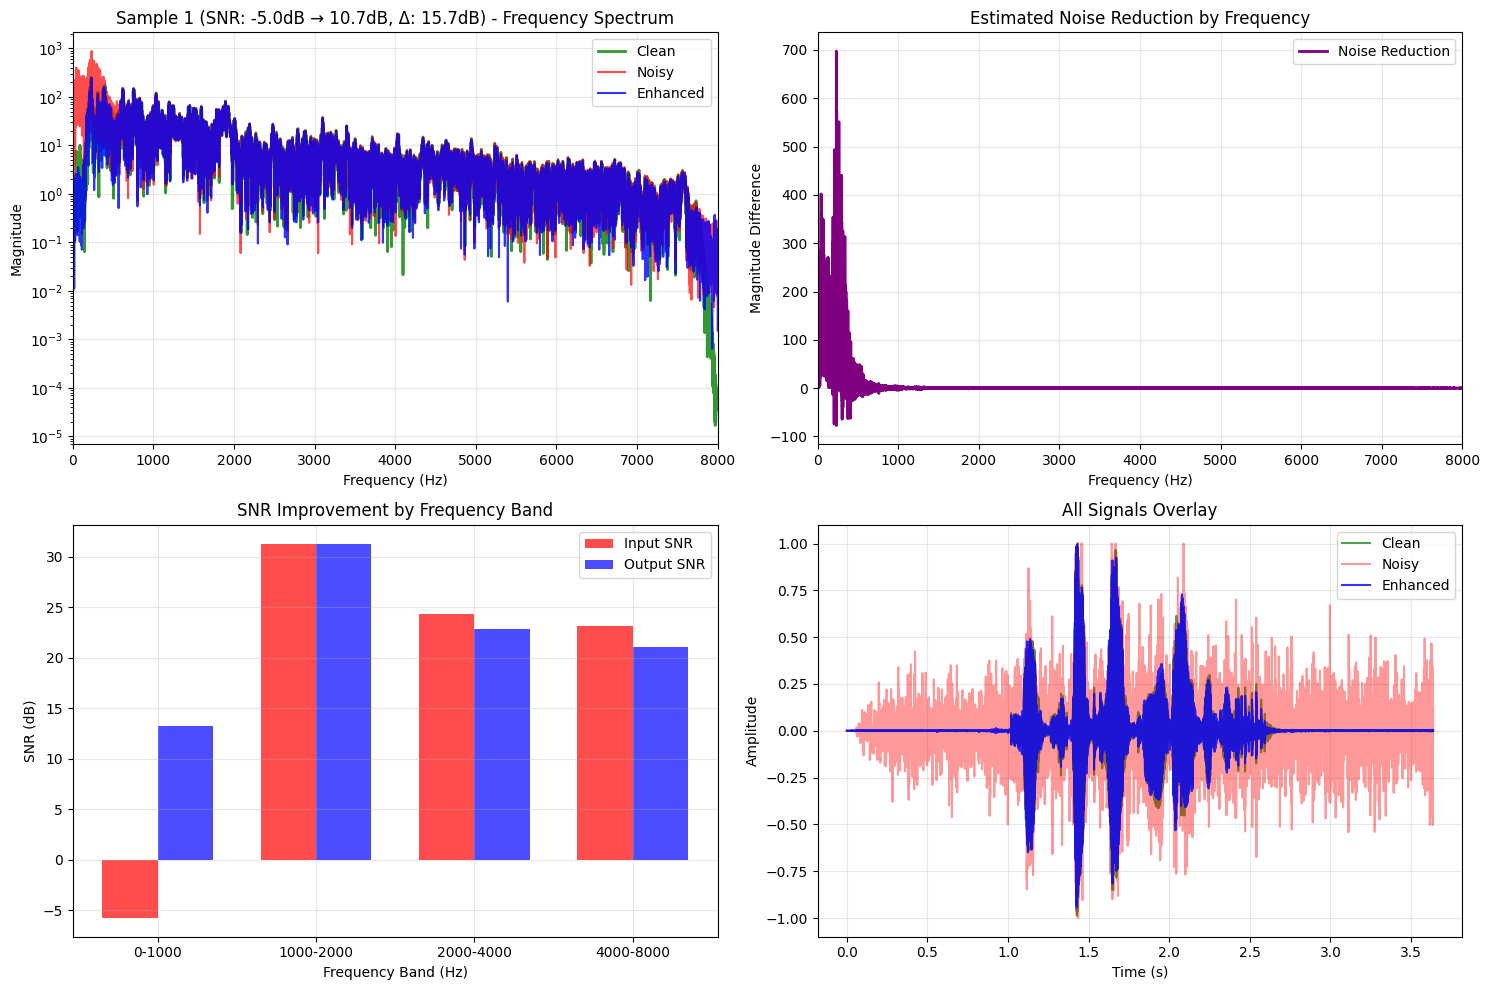

🎧 Audio Playback:



🎵 Evaluating Sample 2/3
💾 Saved enhanced audio: /content/enhanced_audio/03-01-01-01-01-01-02_ambience_snr0dB_enhanced.wav
📊 Sample: 03-01-01-01-01-01-02_ambience_snr0dB
   Input SNR: 0.00 dB
   Output SNR: 13.34 dB
   SNR Improvement: 13.34 dB


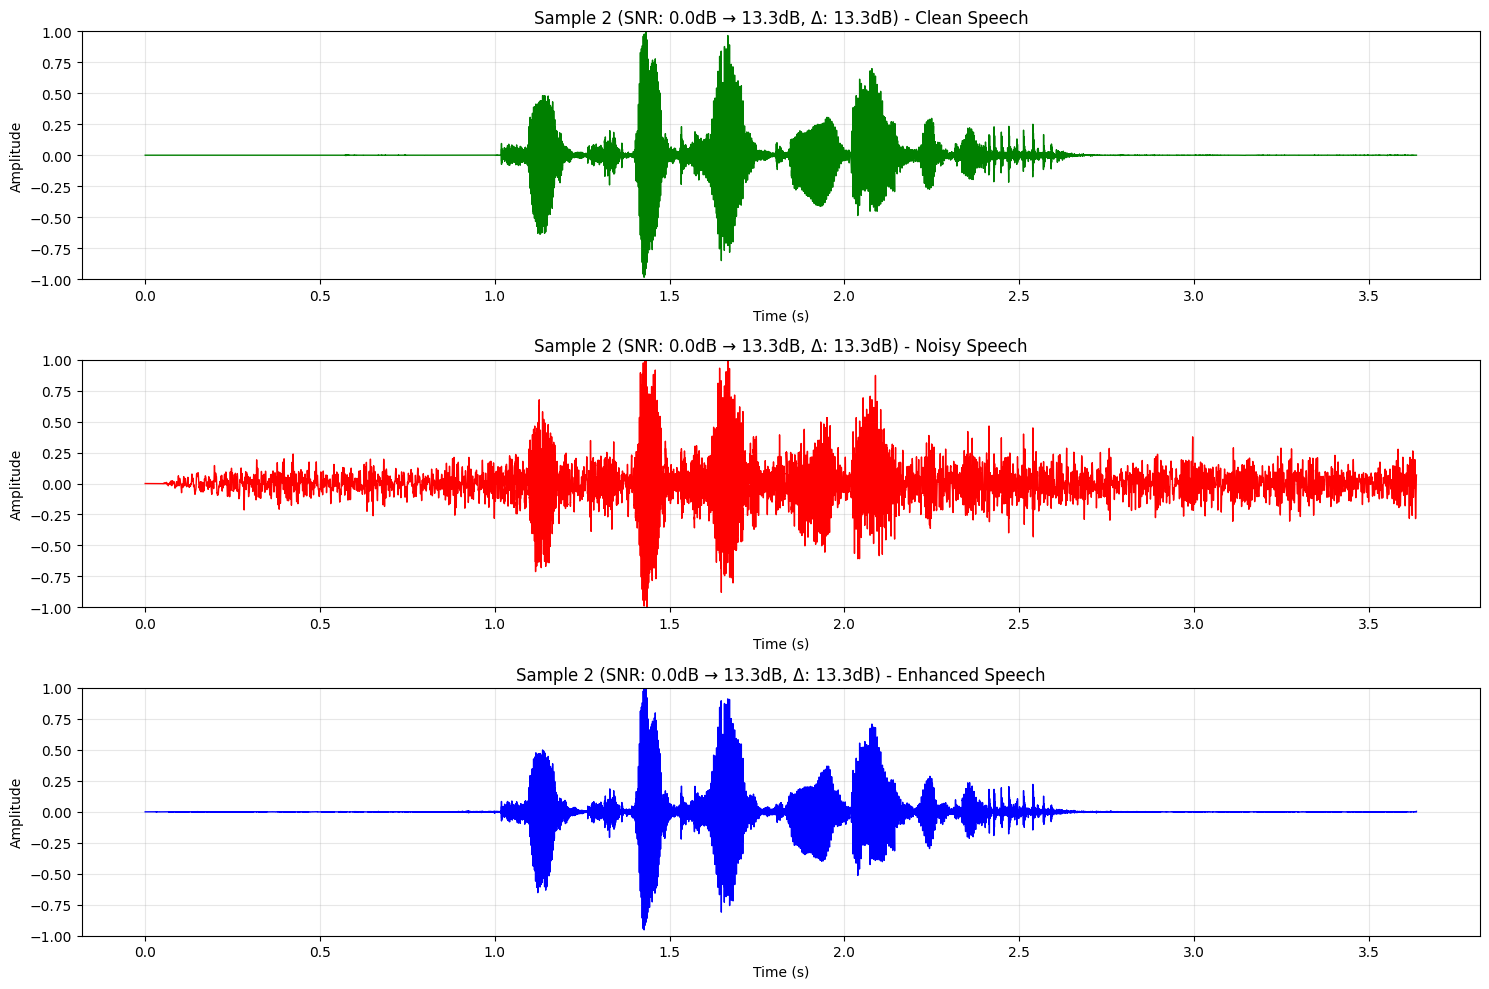

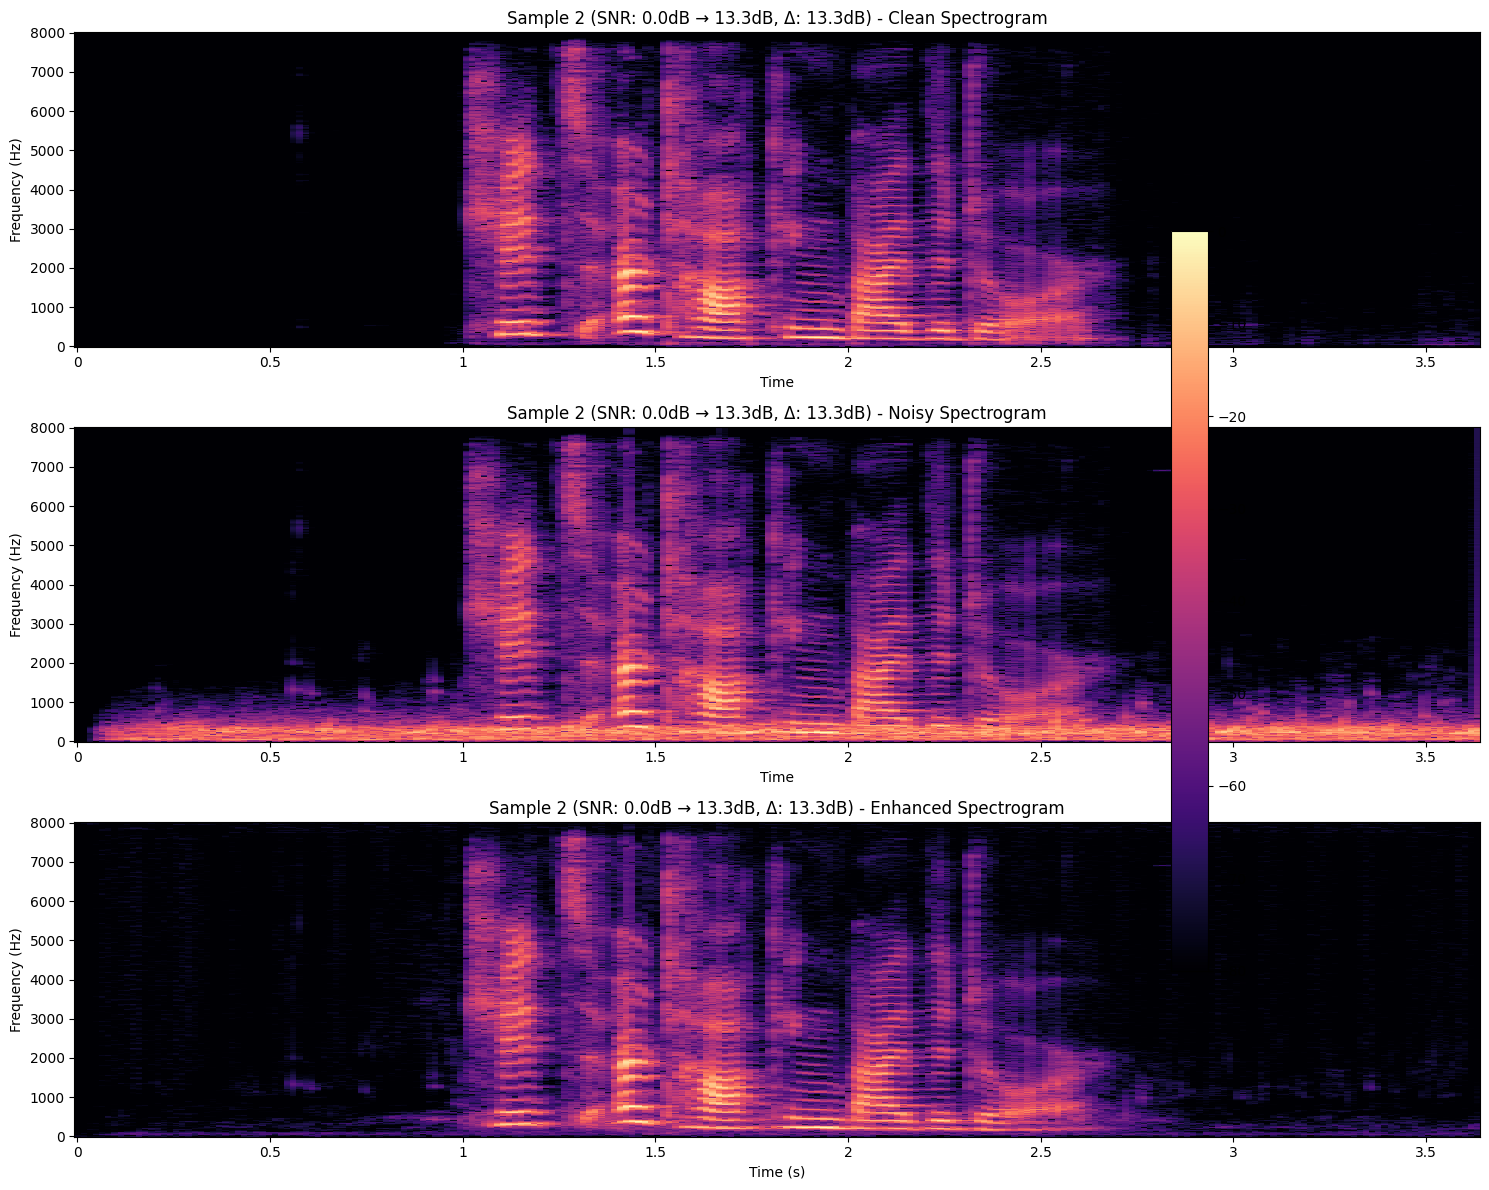

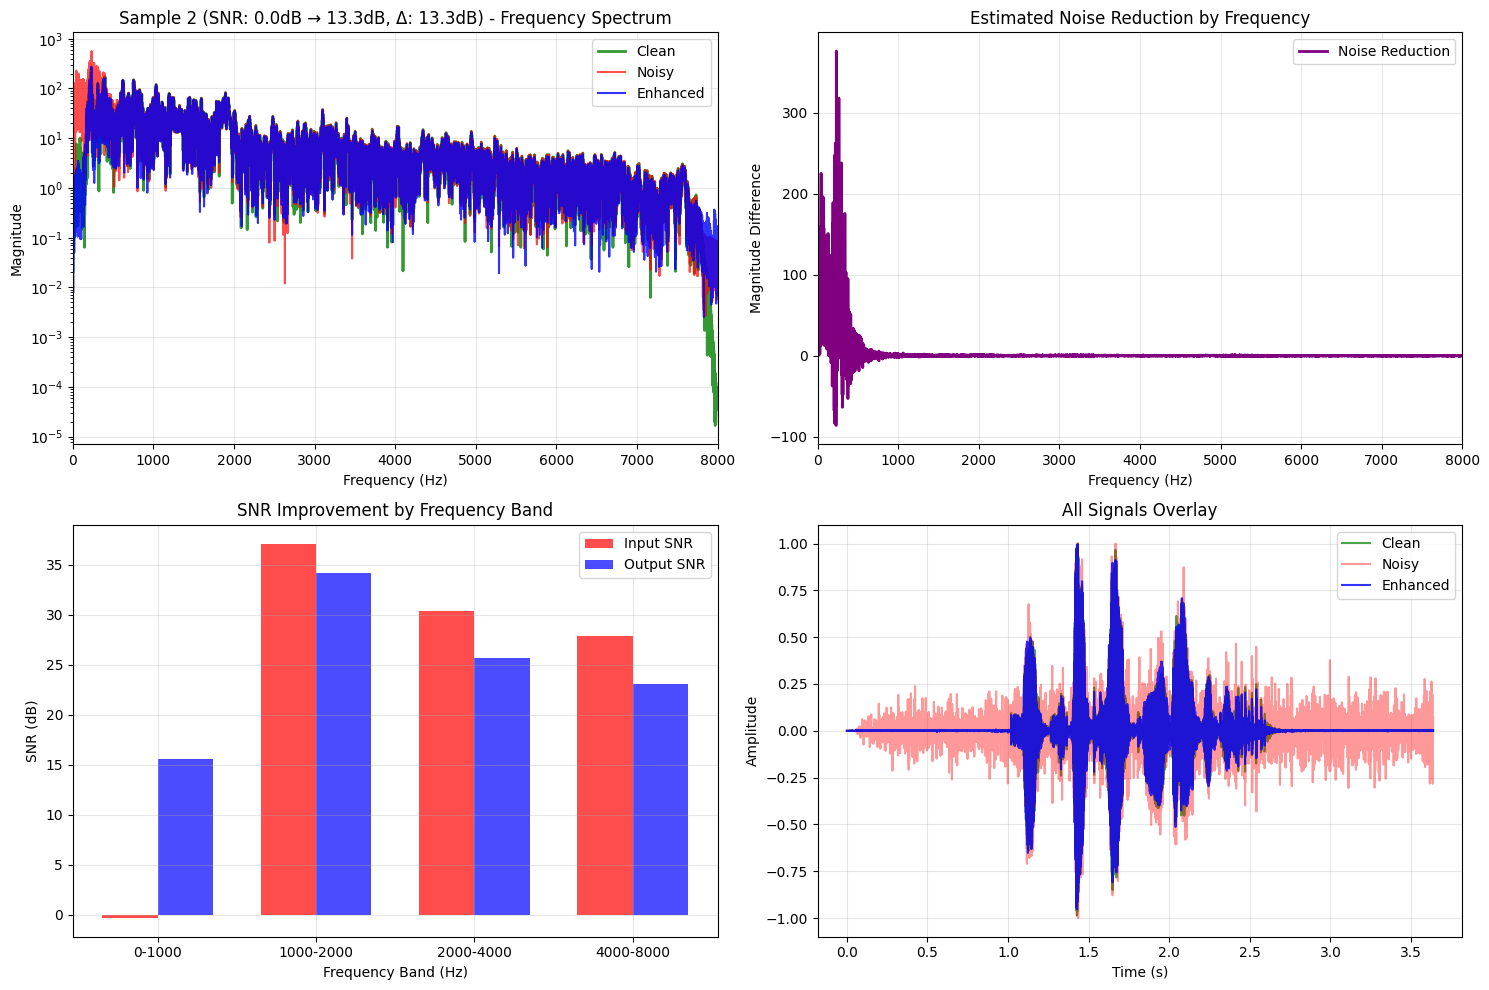

🎧 Audio Playback:



🎵 Evaluating Sample 3/3
💾 Saved enhanced audio: /content/enhanced_audio/03-01-01-01-01-01-02_ambience_snr10dB_enhanced.wav
📊 Sample: 03-01-01-01-01-01-02_ambience_snr10dB
   Input SNR: 10.00 dB
   Output SNR: 18.75 dB
   SNR Improvement: 8.75 dB


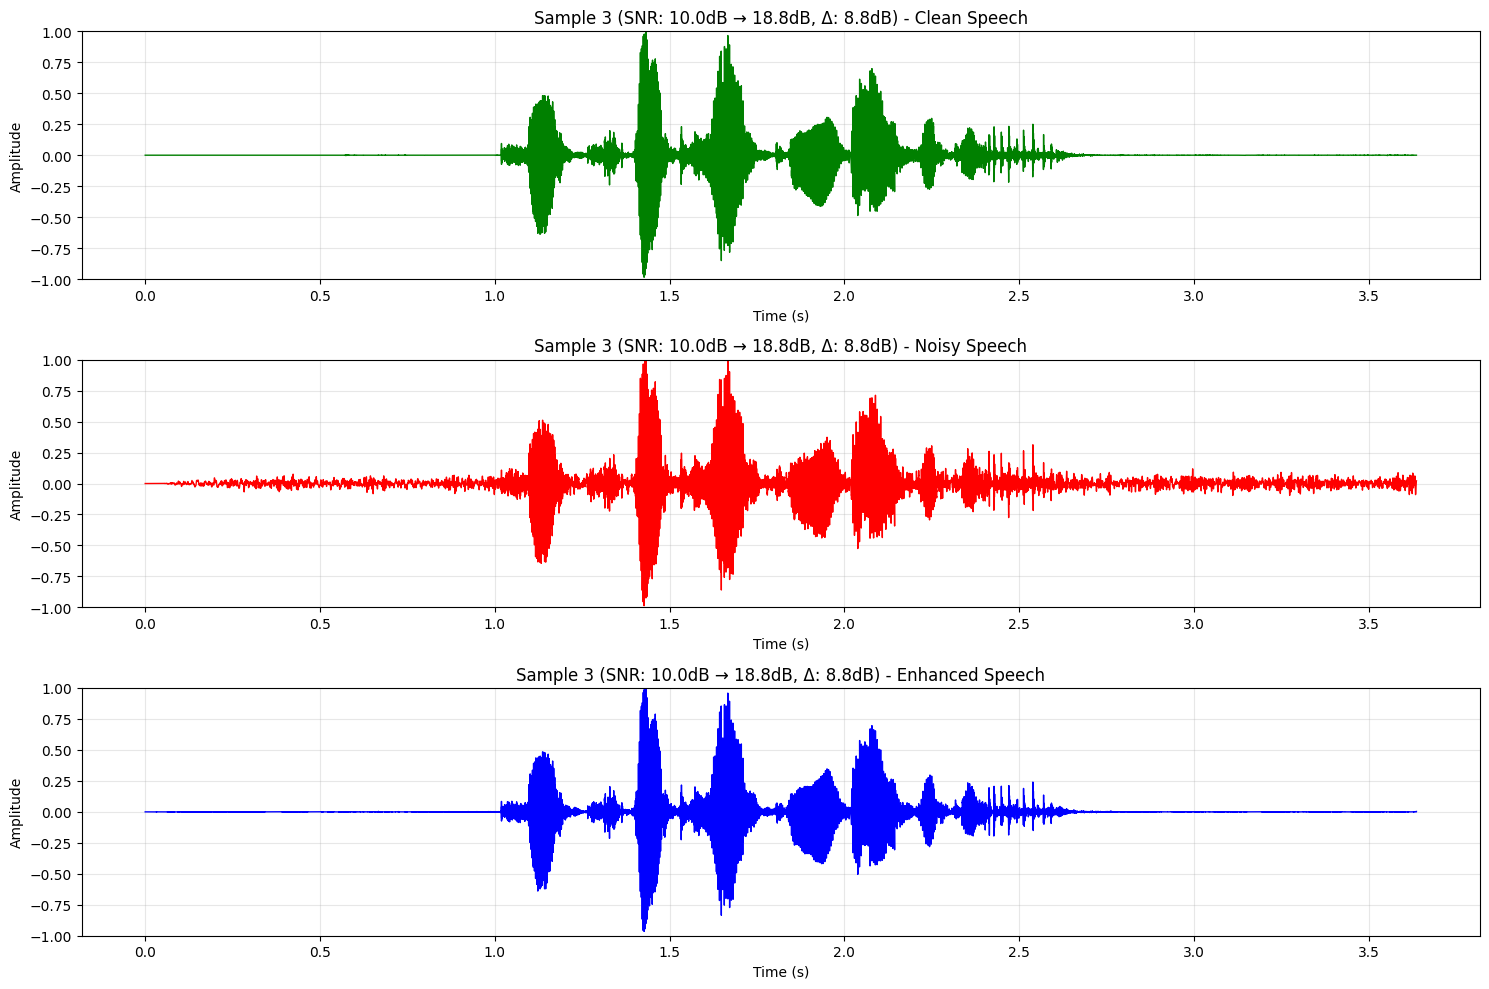

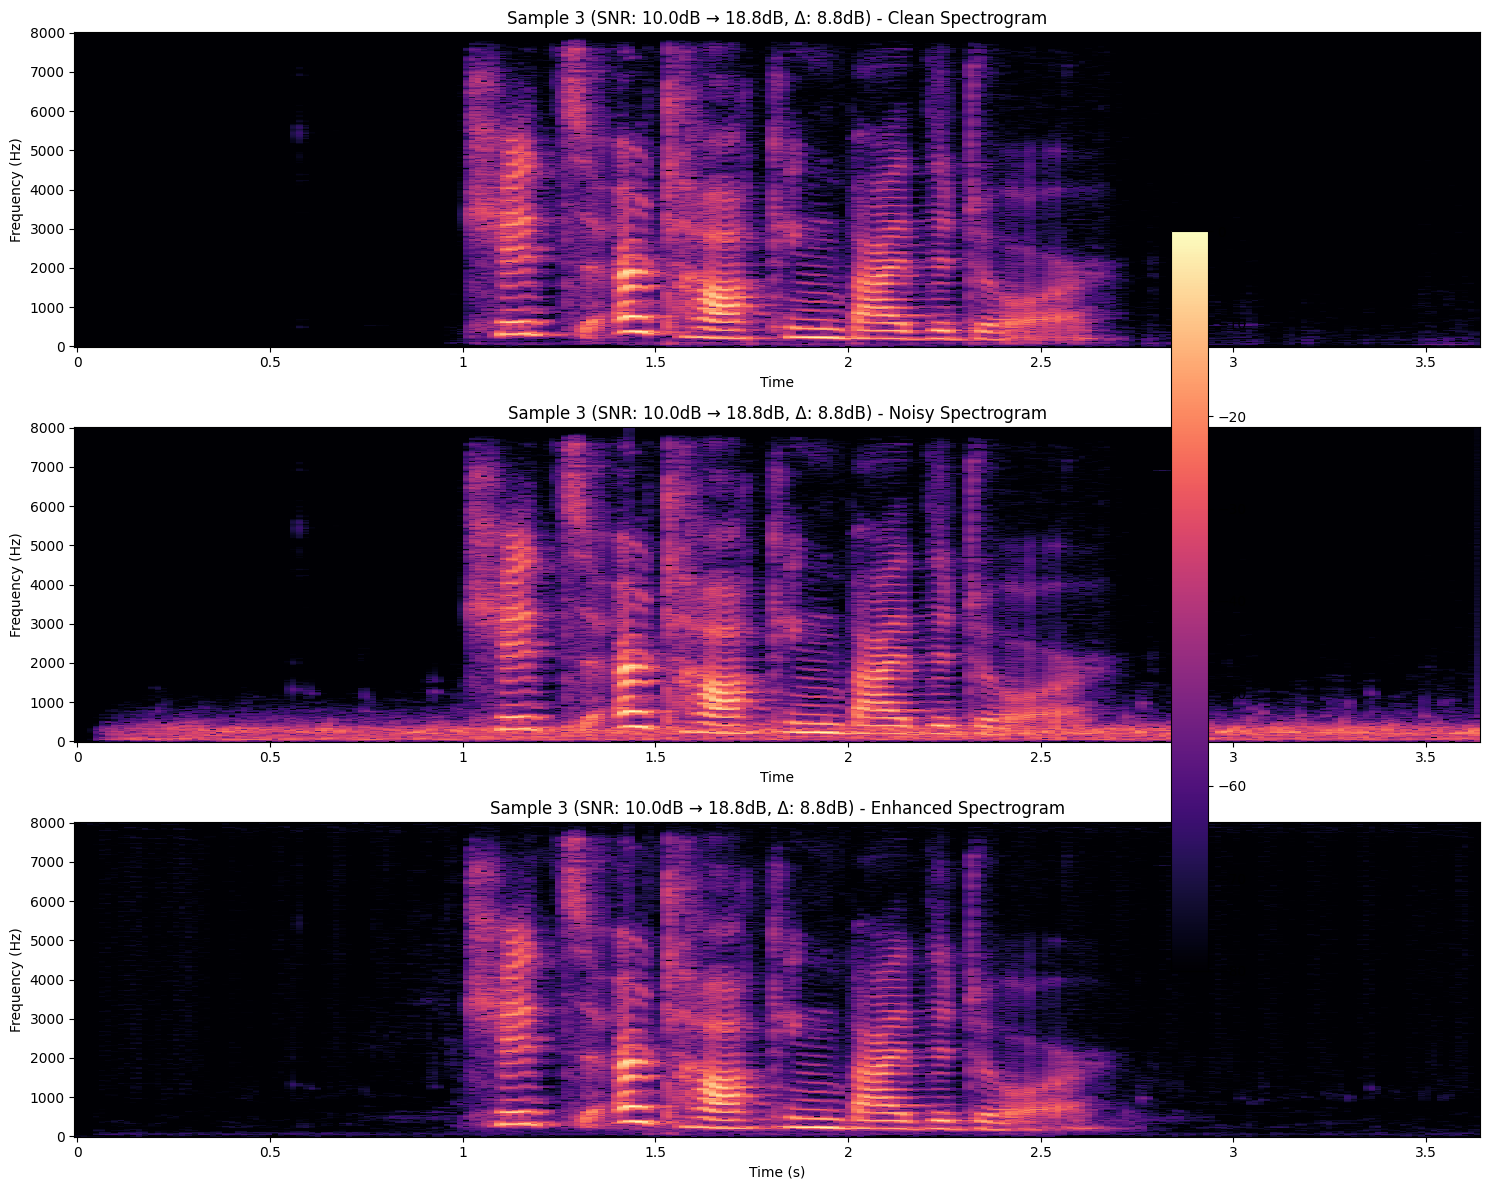

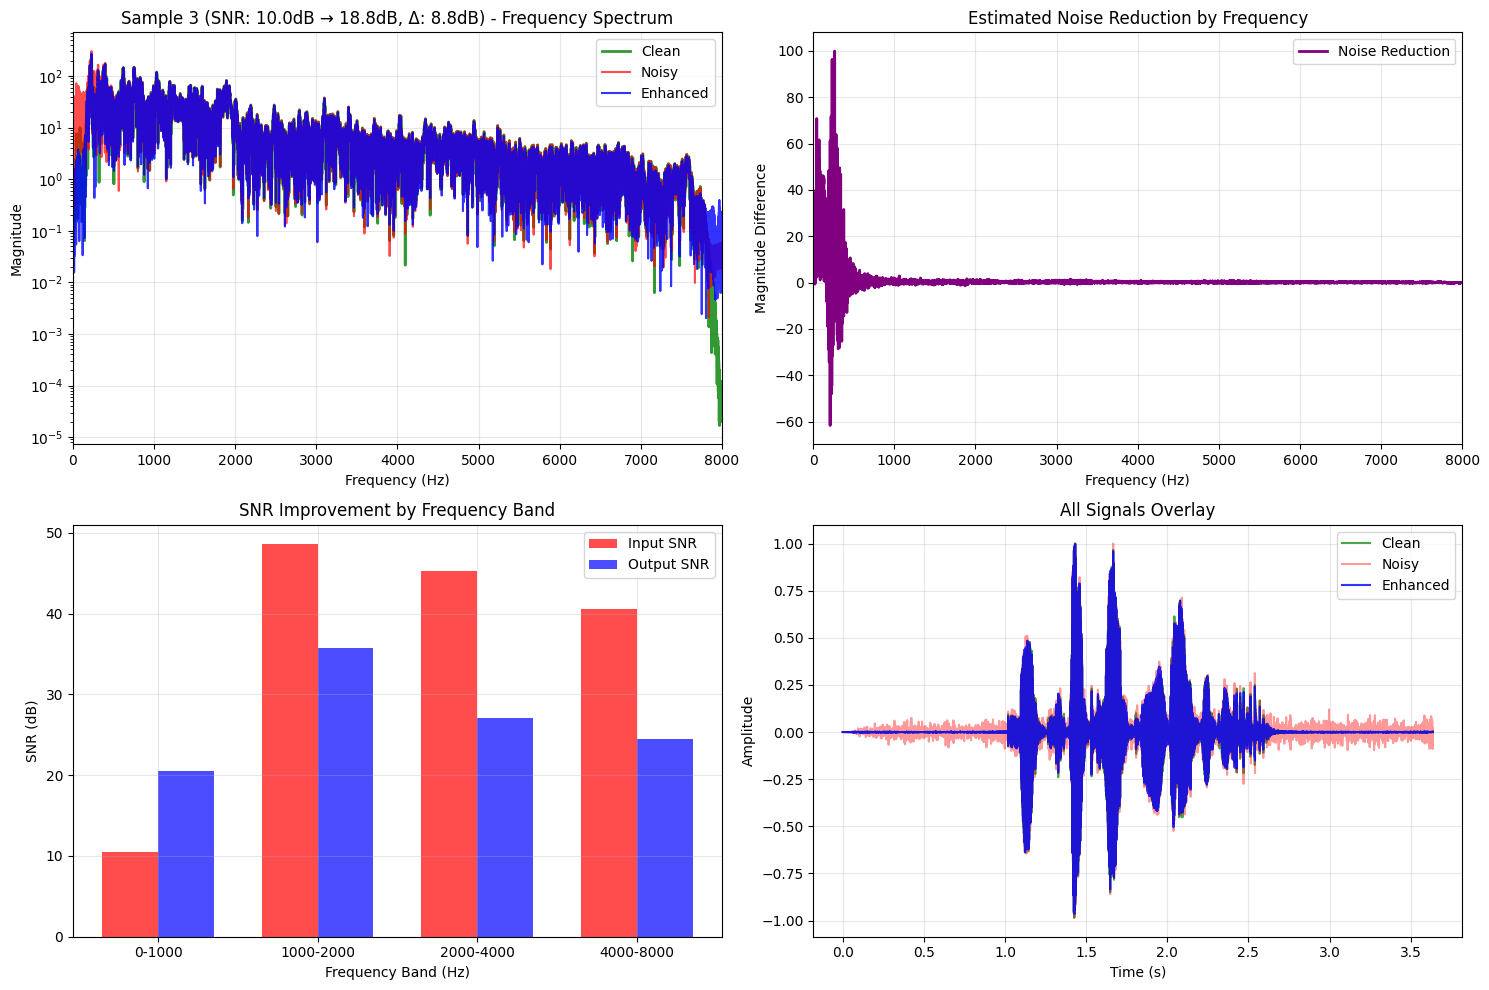

🎧 Audio Playback:



📈 EVALUATION SUMMARY
Sample 1: 03-01-01-01-01-01-02_ambience_snr-5dB
  Input SNR: -5.00 dB
  Output SNR: 10.66 dB
  Improvement: 15.66 dB

Sample 2: 03-01-01-01-01-01-02_ambience_snr0dB
  Input SNR: 0.00 dB
  Output SNR: 13.34 dB
  Improvement: 13.34 dB

Sample 3: 03-01-01-01-01-01-02_ambience_snr10dB
  Input SNR: 10.00 dB
  Output SNR: 18.75 dB
  Improvement: 8.75 dB

🎯 Average SNR Improvement: 12.58 dB

✅ Pipeline completed successfully!
📁 Enhanced audio saved in: /content/enhanced_audio
💾 Model saved as: /content/best_rsunet_colab.pth


In [3]:
# Comprehensive evaluation
print("\n" + "="*70)
print("📊 STARTING COMPREHENSIVE EVALUATION")
print("="*70)

test_files = sorted(os.listdir(noisy_dir_stft))
results = comprehensive_evaluation(trained_model, test_files, noisy_dir_stft, STFT_DIR, MIX_DIR, CLEAN_DIR, ENHANCED_DIR, num_samples=3)

# Print summary
print("\n" + "="*70)
print("📈 EVALUATION SUMMARY")
print("="*70)
for i, result in enumerate(results):
    print(f"Sample {i+1}: {result['file']}")
    print(f"  Input SNR: {result['input_snr']:.2f} dB")
    print(f"  Output SNR: {result['output_snr']:.2f} dB")
    print(f"  Improvement: {result['snr_improvement']:.2f} dB")
    print()

avg_improvement = np.mean([r['snr_improvement'] for r in results])
print(f"🎯 Average SNR Improvement: {avg_improvement:.2f} dB")

print("\n✅ Pipeline completed successfully!")
print(f"📁 Enhanced audio saved in: {ENHANCED_DIR}")
print(f"💾 Model saved as: /content/best_rsunet_colab.pth")